In [ ]:
# we will import all required libraries for this tutorial in advance

import imgaug as ia
ia.seed(1)
# imgaug uses matplotlib backend for displaying images
%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
# imageio library will be used for image input/output
import imageio
import pandas as pd
import numpy as np
import re
import os
import glob
import cv2
# this library is needed to read XML files for converting it into CSV
import xml.etree.ElementTree as ET
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/OCR.zip' -d '/tmp/OCR'

Archive:  /content/drive/MyDrive/OCR.zip
replace /tmp/OCR/ImageAndXML_Data/0000223278.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
image_path = '/tmp/OCR/ImageAndXML_Data/'
# load images as NumPy arrays and append them to images list
images = []
for index, file in enumerate(glob.glob('/tmp/OCR/ImageAndXML_Data/*.tif')):
    images.append(imageio.imread(file))
    
# how many images we have
print('We have {} images'.format(len(images)))

We have 520 images


In [ ]:
# what are the sizes of the images
for index, file in enumerate(glob.glob('/tmp/OCR/ImageAndXML_Data/*.tif')):
    print('Image {} have size of {}'.format(file[7:], images[index].shape))

Image R/ImageAndXML_Data/526509181+-9181.tif have size of (1000, 754)
Image R/ImageAndXML_Data/96403982.tif have size of (1000, 754)
Image R/ImageAndXML_Data/2084021799.tif have size of (1000, 754)
Image R/ImageAndXML_Data/0011500947.tif have size of (1000, 771)
Image R/ImageAndXML_Data/2001213789.tif have size of (1000, 777)
Image R/ImageAndXML_Data/0060181312.tif have size of (1000, 762)
Image R/ImageAndXML_Data/2502268385.tif have size of (1000, 754)
Image R/ImageAndXML_Data/2085540620.tif have size of (1000, 754)
Image R/ImageAndXML_Data/2061828225.tif have size of (1000, 607)
Image R/ImageAndXML_Data/2029377607.tif have size of (1000, 790)
Image R/ImageAndXML_Data/86087317.tif have size of (1000, 754)
Image R/ImageAndXML_Data/86018092.tif have size of (1000, 776)
Image R/ImageAndXML_Data/2074484114.tif have size of (1000, 754)
Image R/ImageAndXML_Data/0060076899.tif have size of (1000, 762)
Image R/ImageAndXML_Data/ti17120370.tif have size of (1000, 754)
Image R/ImageAndXML_Data/9

In [ ]:
# XML file names correspond to the image file names
for index, file in enumerate(glob.glob('/tmp/OCR/ImageAndXML_Data/*.xml')):
    print(file[7:])

R/ImageAndXML_Data/502329893_ocr.xml
R/ImageAndXML_Data/92857672_7674_ocr.xml
R/ImageAndXML_Data/1000031514_gt.xml
R/ImageAndXML_Data/87021931_gt.xml
R/ImageAndXML_Data/514802406+-2409_gt.xml
R/ImageAndXML_Data/97072207_ocr.xml
R/ImageAndXML_Data/2072957848_ocr.xml
R/ImageAndXML_Data/2084021796_gt.xml
R/ImageAndXML_Data/2029377724_gt.xml
R/ImageAndXML_Data/ti10160632_gt.xml
R/ImageAndXML_Data/2042356681_gt.xml
R/ImageAndXML_Data/506413423_gt.xml
R/ImageAndXML_Data/83565599_ocr.xml
R/ImageAndXML_Data/2030138139_gt.xml
R/ImageAndXML_Data/2063610040_ocr.xml
R/ImageAndXML_Data/0060093870_ocr.xml
R/ImageAndXML_Data/2084020274_0276_gt.xml
R/ImageAndXML_Data/2040687664_ocr.xml
R/ImageAndXML_Data/10399225_ocr.xml
R/ImageAndXML_Data/0011899826_gt.xml
R/ImageAndXML_Data/91781209_gt.xml
R/ImageAndXML_Data/2084022002_ocr.xml
R/ImageAndXML_Data/80233633_ocr.xml
R/ImageAndXML_Data/80233716_ocr.xml
R/ImageAndXML_Data/0060088007_gt.xml
R/ImageAndXML_Data/2063207059_7062_ocr.xml
R/ImageAndXML_Data/2029

In [ ]:
# Function that will extract column data for our CSV file
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        etree = ET.parse(xml_file)
        ns = {'ms' : 'http://schema.primaresearch.org/PAGE/gts/pagecontent/2013-07-15'}
        myroot = etree.getroot()
        page = myroot.find(".//ms:Page", ns)
        for children in list(page):
          if children.find(".//ms:TextLine",ns):
            coord = children.find(".//ms:Coords",ns).get("points")
            value = (page.get('imageFilename'),
                     int(page.get('imageWidth')),
                     int(page.get('imageHeight')),
                     int(coord.split(" ")[0].split(",")[0]),
                     int(coord.split(" ")[0].split(",")[1]),
                     int(coord.split(" ")[1].split(",")[0]),
                     int(coord.split(" ")[2].split(",")[1])
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [ ]:
# apply xml_to_csv() function to convert all XML files in images/ folder into labels.csv
labels_df = xml_to_csv(image_path)
labels_df.to_csv(('labels.csv'), index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.


In [ ]:
labels_df

,filename,width,height,xmin,ymin,xmax,ymax
0,502329893.tif,766,1000,9,17,132,75
1,502329893.tif,766,1000,190,9,210,20
2,502329893.tif,766,1000,236,4,256,11
3,502329893.tif,766,1000,20,92,71,104
4,502329893.tif,766,1000,21,134,75,155
...,...,...,...,...,...,...,...
13787,2084022347.tif,754,1000,353,258,406,297
13788,2084022347.tif,754,1000,439,258,487,277
13789,2084022347.tif,754,1000,521,257,579,297
13790,2084022347.tif,754,1000,47,913,155,923


In [ ]:
# start by groupping each image bounding boxes coordinates
# separate dataframes are formed based on the filename
grouped = labels_df.groupby('filename')

In [ ]:
# we can pull each group with get_group() using the filename
group_df = grouped.get_group('00920343.tif')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
group_df

,filename,width,height,xmin,ymin,xmax,ymax
0,00920343.tif,762,1000,112,39,298,80
1,00920343.tif,762,1000,114,108,259,177
2,00920343.tif,762,1000,260,199,443,213
3,00920343.tif,762,1000,115,259,207,276
4,00920343.tif,762,1000,114,335,321,413
5,00920343.tif,762,1000,114,441,312,557
6,00920343.tif,762,1000,219,588,478,645
7,00920343.tif,762,1000,264,802,476,879
8,00920343.tif,762,1000,273,923,448,938
9,00920343.tif,762,1000,523,489,592,528


In [ ]:
# get bounding boxes coordinates from grouped data frame and write into array        
bb_array = group_df.drop(['filename', 'width', 'height'], axis=1).values
# display the array we've got
a = np.array(bb_array)
a1 = np.empty((len(bb_array),), dtype=object)
a1[:] = [tuple(i) for i in a]
a1

array([(112, 39, 298, 80), (114, 108, 259, 177), (260, 199, 443, 213),
       (115, 259, 207, 276), (114, 335, 321, 413), (114, 441, 312, 557),
       (219, 588, 478, 645), (264, 802, 476, 879), (273, 923, 448, 938),
       (523, 489, 592, 528), (114, 957, 350, 973), (653, 805, 670, 897)],
      dtype=object)

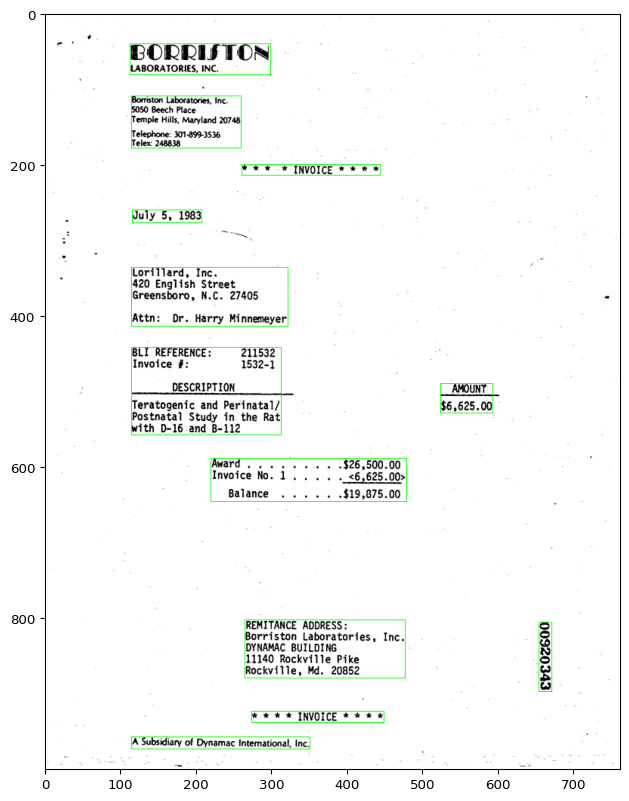

In [ ]:
# pass the array of bounding boxes coordinates to the imgaug library
im = imageio.imread(os.path.join(image_path,"00920343.tif"))
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=im.shape)
# display the image and draw bounding boxes
backtorgb = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
a = bbs.draw_on_image(backtorgb)
ia.imshow(a)

In [ ]:
height_resize = iaa.Sequential([ 
    iaa.Resize({"height": 150, "width": 'keep-aspect-ratio'})
])

In [ ]:
# function to convert BoundingBoxesOnImage object into DataFrame
def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

In [ ]:
def resize_imgaug(df, images_path, aug_images_path, image_prefix):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')    
    
    for filename in df['filename'].unique():
    #   Get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)
        
    #   If image height is greater than or equal to image width 
    #   AND greater than 600px perform resizing augmentation shrinking image height to 600px.
        if group_df['height'].unique()[0] > 150:
        #   read the image
            image = imageio.imread(images_path+filename)
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['filename', 'width', 'height'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = height_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])
            
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [ ]:
resized_path = '/tmp/OCR/resized/'
if not os.path.exists(resized_path):
  os.makedirs(resized_path)
resized_images_df = resize_imgaug(labels_df, image_path, resized_path, '')

In [ ]:
# display new DataFrame
resized_images_df

,filename,width,height,xmin,ymin,xmax,ymax
0,502329893.tif,115,150,1.351175,2.550000,19.817232,11.250000
1,502329893.tif,115,150,28.524805,1.350000,31.527416,3.000000
2,502329893.tif,115,150,35.430809,0.600000,38.433422,1.650000
3,502329893.tif,115,150,3.002611,13.800000,10.659269,15.600000
4,502329893.tif,115,150,3.152741,20.100000,11.259790,23.250000
...,...,...,...,...,...,...,...
13787,2084022347.tif,113,150,52.903183,38.699997,60.846157,44.549999
13788,2084022347.tif,113,150,65.791779,38.699997,72.985405,41.550003
13789,2084022347.tif,113,150,78.080902,38.549999,86.773209,44.549999
13790,2084022347.tif,113,150,7.043766,136.949997,23.229443,138.449997


In [ ]:
# overwrite the labels.csv with updated info
resized_images_df.to_csv('labels.csv', index=False)

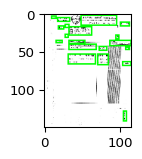

In [ ]:
# visualise the resized valentin-petkov-loL9nnBK-fE-unsplash.jpg image with bounding boxes
# to make sure our bounding boxes were resized correctly as well
grouped = resized_images_df.groupby('filename')
group_df = grouped.get_group('00555341.tif')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
bb_array = group_df.drop(['filename', 'width', 'height'], axis=1).values
im = imageio.imread(os.path.join(resized_path,'00555341.tif'))
backtorgb = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=backtorgb.shape)
ia.imshow(bbs.draw_on_image(backtorgb, size=2))

In [ ]:
a = resized_images_df.groupby('filename')

In [ ]:
train_images = []
train_targets = []

grouped = resized_images_df.groupby('filename')
for index,row in resized_images_df.iterrows():
    
    (filename, width, height, xmin, ymin, xmax, ymax) = row
    
    
    train_image_fullpath = os.path.join(resized_path, filename)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(150, 120))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)
    
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))
    
    

In [ ]:
#create the common input layer
input_shape = (150, 120, 3)
input_layer = tf.keras.layers.Input(input_shape)

#create the base layers
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

In [ ]:
#create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch) 

In [ ]:
model = tf.keras.Model(input_layer,
           outputs=locator_branch)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 120, 3)]     0         
                                                                 
 bl_1 (Rescaling)            (None, 150, 120, 3)       0         
                                                                 
 bl_2 (Conv2D)               (None, 150, 120, 16)      448       
                                                                 
 bl_3 (MaxPooling2D)         (None, 75, 60, 16)        0         
                                                                 
 bl_4 (Conv2D)               (None, 75, 60, 32)        4640      
                                                                 
 bl_5 (MaxPooling2D)         (None, 37, 30, 32)        0         
                                                                 
 bl_6 (Conv2D)               (None, 37, 30, 64)        18496 

In [ ]:
losses = {"bb_head":tf.keras.losses.MSE}
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [ ]:
a_train_images = np.asarray(train_images)
a_train_targets = np.asarray(train_targets)
#print(train_images.shape)
#print(train_targets.shape)
#train_images = np.array(train_images, dtype=np.float32)
#train_targets = (train_targets, dtype=np.float32)

trainTargets, testTargets = train_test_split(a_train_targets, test_size=0.2)
trainImages, testImages = train_test_split(a_train_images, test_size=0.2)
#print(trainTargets.dtypes)
#print(trainImages[0].shape)

#trT = tf.ragged.constant(trainTargets)
#teT = tf.ragged.constant(testTargets)

In [ ]:
history = model.fit(trainImages, trainTargets,
             validation_data=(testImages, testTargets),
             batch_size=4,
             epochs=20,
             shuffle=True,
             verbose=1)

Epoch 1/20
2759/2759 [==============================] - 299s 108ms/step - loss: 0.0616 - accuracy: 0.6532 - val_loss: 0.0614 - val_accuracy: 0.6658
Epoch 2/20
2759/2759 [==============================] - 296s 107ms/step - loss: 0.0614 - accuracy: 0.6540 - val_loss: 0.0612 - val_accuracy: 0.6658
Epoch 3/20
2759/2759 [==============================] - 299s 108ms/step - loss: 0.0614 - accuracy: 0.6540 - val_loss: 0.0612 - val_accuracy: 0.6658
Epoch 4/20
2759/2759 [==============================] - 299s 108ms/step - loss: 0.0614 - accuracy: 0.6540 - val_loss: 0.0612 - val_accuracy: 0.6658
Epoch 5/20
2759/2759 [==============================] - 301s 109ms/step - loss: 0.0613 - accuracy: 0.6540 - val_loss: 0.0613 - val_accuracy: 0.6658
Epoch 6/20
2759/2759 [==============================] - 305s 111ms/step - loss: 0.0613 - accuracy: 0.6540 - val_loss: 0.0612 - val_accuracy: 0.6658
Epoch 7/20
2759/2759 [==============================] - 303s 110ms/step - loss: 0.0613 - accuracy: 0.6540 - val_